<h1><center>Sickness Prediction</center></h1>

Use [NbViewer](https://nbviewer.jupyter.org/) to view the rendered notebook.

## Contents

1. [Task Overview](#1.-Task-Overview)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Data Visualization](#3.-Data-Visualization)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Train Test Data Split](#5.-Train-Test-Data-Split)
6. [Build, Train, Evaluate the Model](#6.-Build,-Train,-Evaluate-the-Model)
7. [Test Model](#7.-Test-Model)
8. [Conclusion](#8.-Conclusion)
9. [References](#9.-References)

### 1. Task Overview

The objective of this task is to predict whether an individual will be sick the following day.<br> 
Target variable - `Offset_Sick_Day` 

The complexity of the task lies in the fact that it deals with time-indexed data and different individuals.
We can use any features existing in the dataset except for the `ID` feature. The model is evaluated based on *Matthew Correlation Coefficients (MCC)*, and hence the goal is to optimize it for this particular metric. <br><br>
**Data Description** <br>

Training set - train.csv<br>
Test set - holdout.csv<br>


- There are **7** columns in the dataset that are considered sickness indicators: `Temperature`, `Onset Latency`, `Duration Integer hr`, `HR Lowest`, `rMSSD`, `Breath Average`, `Temperature Delta`
- For each of these seven indicators, we take the 3-day rolling mean
- If the 3-day rolling mean on a particular day is abnormal compared to the historical 3-day rolling mean, then that indicator indicates sickness
- If two or more of the 7 indicators indicate sickness, then the individual is said to be sick on the given day
- The target is then offset so that we’re making a prediction about whether an individual will be sick the next day

### 2. Exploratory Data Analysis

Before we load the dataset, we will set up our environment by importing necessary libraries.

In [1]:
#Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#For more info on arguments of seaborn.set()
#https://seaborn.pydata.org/generated/seaborn.set.html

#Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

#Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8,5)
#This works as well - plt.rcParams['figure.figsize'] = 8,5
plt.rcParams['image.cmap'] = 'viridis'

import pandas as pd
import numpy as np


from sklearn.manifold import TSNE

#### 2.1 Load and Read the dataset

In [2]:
#List the train and test directories
TRAIN_DIR = 'data/train.csv'
TEST_DIR = 'data/holdout.csv'

In [3]:
#Load train dataset
train_df = pd.read_csv(TRAIN_DIR)
test_df = pd.read_csv(TEST_DIR)

In [4]:
#Printing the shape of the dataframe(s)
print('Shape of train_df dataframe: {}'.format(train_df.shape))
print('Shape of test_df dataframe: {}'.format(test_df.shape))

Shape of train_df dataframe: (22267, 70)
Shape of test_df dataframe: (5565, 70)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22267 entries, 0 to 22266
Data columns (total 70 columns):
Date                                                      22267 non-null object
ID                                                        22267 non-null object
Duration Integer hr                                       20923 non-null float64
Sleep Score                                               20923 non-null float64
Score Efficiency                                          20923 non-null float64
Onset Latency                                             20923 non-null float64
HR Lowest                                                 20884 non-null float64
HR Average                                                20884 non-null float64
rMSSD                                                     20880 non-null float64
Temperature Delta                                         20827 non-null float64
Temperature                                               5553 non-null float64
Bre

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5565 entries, 0 to 5564
Data columns (total 70 columns):
Date                                                      5565 non-null object
ID                                                        5565 non-null object
Duration Integer hr                                       5187 non-null float64
Sleep Score                                               5187 non-null float64
Score Efficiency                                          5187 non-null float64
Onset Latency                                             5187 non-null float64
HR Lowest                                                 5182 non-null float64
HR Average                                                5182 non-null float64
rMSSD                                                     5182 non-null float64
Temperature Delta                                         5173 non-null float64
Temperature                                               1400 non-null float64
Breath Average 

In [7]:
print(f'There are {train_df.isnull().any().sum()} columns in training dataset with missing values')
print(f'There are {test_df.isnull().any().sum()} columns in test dataset with missing values')

There are 67 columns in training dataset with missing values
There are 67 columns in test dataset with missing values


**Observations**

- Both `train_df` and `test_df` have 70 columns(features), out of which 2 are `object`, 1 is `int64` and 67 are `float64` datatypes
- Barring `Date`, `ID` and `Offset_Sick_Day` every feature in both train and test dataset contains null values

#### 2.2 Understanding the dataset

Let us try to identify the features in the dataset that corresponds to the below statements listed in italics.<br><br>
*For each of these seven indicators, we take the 3-day rolling mean* <br>
*If the 3-day rolling mean on a particular day is abnormal compared to the historical 3-day rolling mean, then that indicator indicates sickness* <br>
*If two or more of the 7 indicators indicate sickness, then the individual is said to be sick on the given day*

For a given sickness indicator, 

- The 3-day rolling mean is represented by `Rolling_sickness_indicator_3` in the dataset
- The historical 3-day rolling mean is represented by `Rolling_sickness_indicator_3_distribution_mean` in the dataset
- There are various features like mean, historical mean, iqr, outlier, upper, lower, sigma values

Consider `Breath Average` as an example to verify the above, 

`Rolling_Breath_Average_3` on 2020-03-30 is the average value of `Breath Average` ranging from 28th-30th March 2020 and is valued at **15.53**

If we  take a look at the 5th April 2020 record, the individual is sick. This means that *3-day rolling mean* is abnormal compared to the *historical 3-day rolling mean* for atleast a couple of sickness indicators on this given day.

However, it is unclear if `Breath Average` played any part in determining the sickness. This is because there is no clear definition on abnormality factor discussed above. 

In [8]:
#Display data related to 'Breath Average'
train_df[['Date', 'ID', 'Breath Average', 'Rolling_Breath Average_3',\
          'Rolling_Breath Average_3_distribution_mean', 'Sick_Day']].head()

,Date,ID,Breath Average,Rolling_Breath Average_3,Rolling_Breath Average_3_distribution_mean,Sick_Day
0,2020-03-28,Athlete Finomore9999,15.6,15.500000,NaN,NaN
1,2020-03-29,Athlete Finomore9999,15.5,15.566667,15.321667,0.0
2,2020-03-30,Athlete Finomore9999,15.5,15.533333,15.343939,0.0
3,2020-03-31,Athlete Finomore9999,15.9,15.633333,15.359722,0.0
4,2020-04-01,Athlete Finomore9999,15.6,15.666667,15.380769,0.0


#### 2.3 Identifying the missing values

We will find the percentage of missing(NaN) values for each feature in both training and test dataset.

In [9]:
#Percentage of null values in each feature of 'train_df'
null_values_train = train_df.isnull().sum()/len(train_df)*100

In [10]:
#Top 10 features with maximum null values in training set
null_values_train.sort_values(ascending=False)[:10]

Rolling_Temperature_3_tukey_outlier               78.362599
Temperature                                       75.061751
Rolling_Temperature_3                             74.424036
Rolling_Temperature_3_distribution_tukey_lower    57.493151
Rolling_Temperature_3_distribution_iqr            57.493151
Rolling_Temperature_3_distribution_sigma          57.493151
Rolling_Temperature_3_distribution_tukey_upper    57.493151
Rolling_Temperature_3_distribution_mean           57.493151
Age                                               39.448511
Sex                                               39.277855
dtype: float64

In [11]:
#Percentage of null values in each feature of 'test_df'
null_values_test = test_df.isnull().sum()/len(test_df)*100

In [12]:
#Top 10 features with maximum null values in test set
null_values_test.sort_values(ascending=False)[:10]

Rolling_Temperature_3_tukey_outlier               77.232704
Temperature                                       74.842767
Rolling_Temperature_3                             74.627134
Rolling_Temperature_3_distribution_sigma          58.023360
Rolling_Temperature_3_distribution_mean           58.023360
Rolling_Temperature_3_distribution_tukey_upper    58.023360
Rolling_Temperature_3_distribution_tukey_lower    58.023360
Rolling_Temperature_3_distribution_iqr            58.023360
Age                                               43.432165
Sex                                               43.090746
dtype: float64

**Observations**

- It is evident amongst all sickness indicators, `Temperature` is the one with more than 50% missing values in both training and test datasets

### 3. Data Visualization

Let us visualize the training dataset by plotting various plots such as histogram, correlation matrix etc.

#### 3.1 Histogram of all features

We will start with plotting histograms for training dataset. Note: Histograms can only be built for numeric features and hence a little pre-processing is required to either

a) eliminate features containing string-values<br>
b) convert them to numeric values if possible


We will focus on the distribution of features related to sickness indicators, namely *3-day rolling mean* and *historical 3-day rolling mean* along with `Sick_Day`

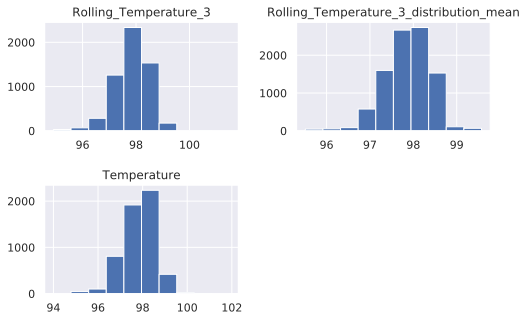

In [13]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['Temperature', 'Rolling_Temperature_3', 'Rolling_Temperature_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

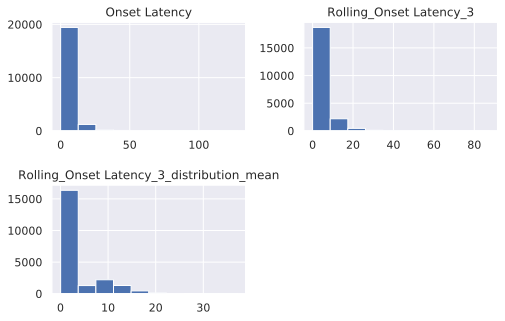

In [14]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['Onset Latency', 'Rolling_Onset Latency_3', 'Rolling_Onset Latency_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

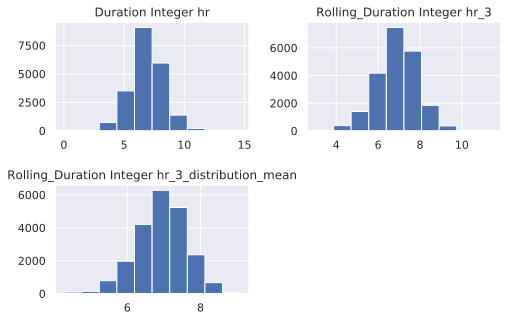

In [15]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['Duration Integer hr', 'Rolling_Duration Integer hr_3', 'Rolling_Duration Integer hr_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

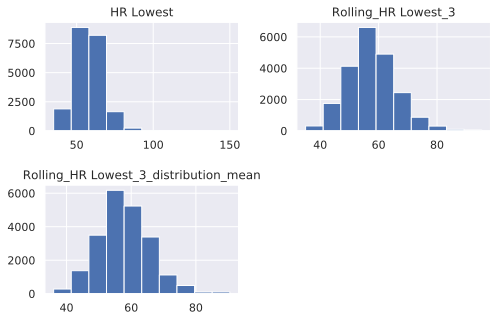

In [16]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['HR Lowest', 'Rolling_HR Lowest_3', 'Rolling_HR Lowest_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

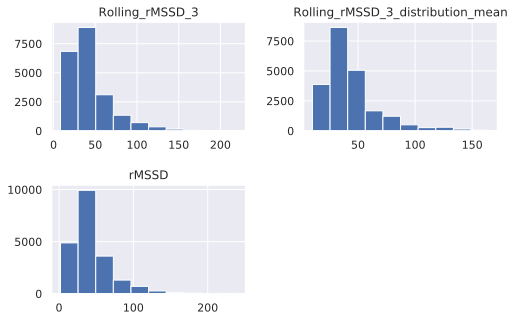

In [17]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['rMSSD', 'Rolling_rMSSD_3', 'Rolling_rMSSD_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

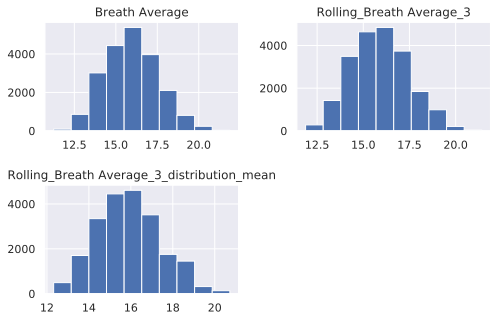

In [18]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['Breath Average', 'Rolling_Breath Average_3', 'Rolling_Breath Average_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

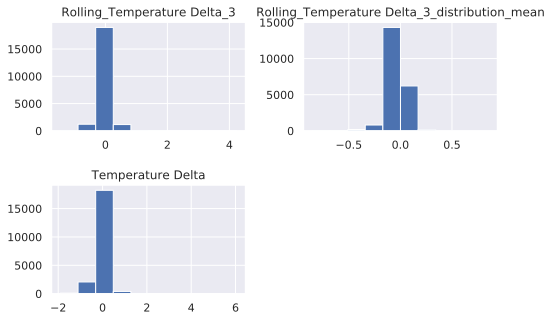

In [19]:
plt.rcParams['figure.figsize'] = (8,5)
train_df[['Temperature Delta', 'Rolling_Temperature Delta_3', 'Rolling_Temperature Delta_3_distribution_mean']].hist();
plt.subplots_adjust(hspace=0.5);

**Observations**

- Most of the records for `Temperature` lie in the range of 97-99 with the most frequent value being **98.6**. This implies the temperature is in Fahrenheit(F) and as seen, more often than not normal body temperature is recorded
- Features related to `Onset Latency` hover around zero
- Features relating to `Duration Integer hr`, `HR Lowest`, `Breath Average` have more or less uniform distribution
- Few values for features related to `rMSSD` are above 75 pointing to a presence of outliers, with the max value being recorded at **239**
- Almost all the values for `Temperature Delta` are recorded as **0**

#### 3.2 Correlation Matrix

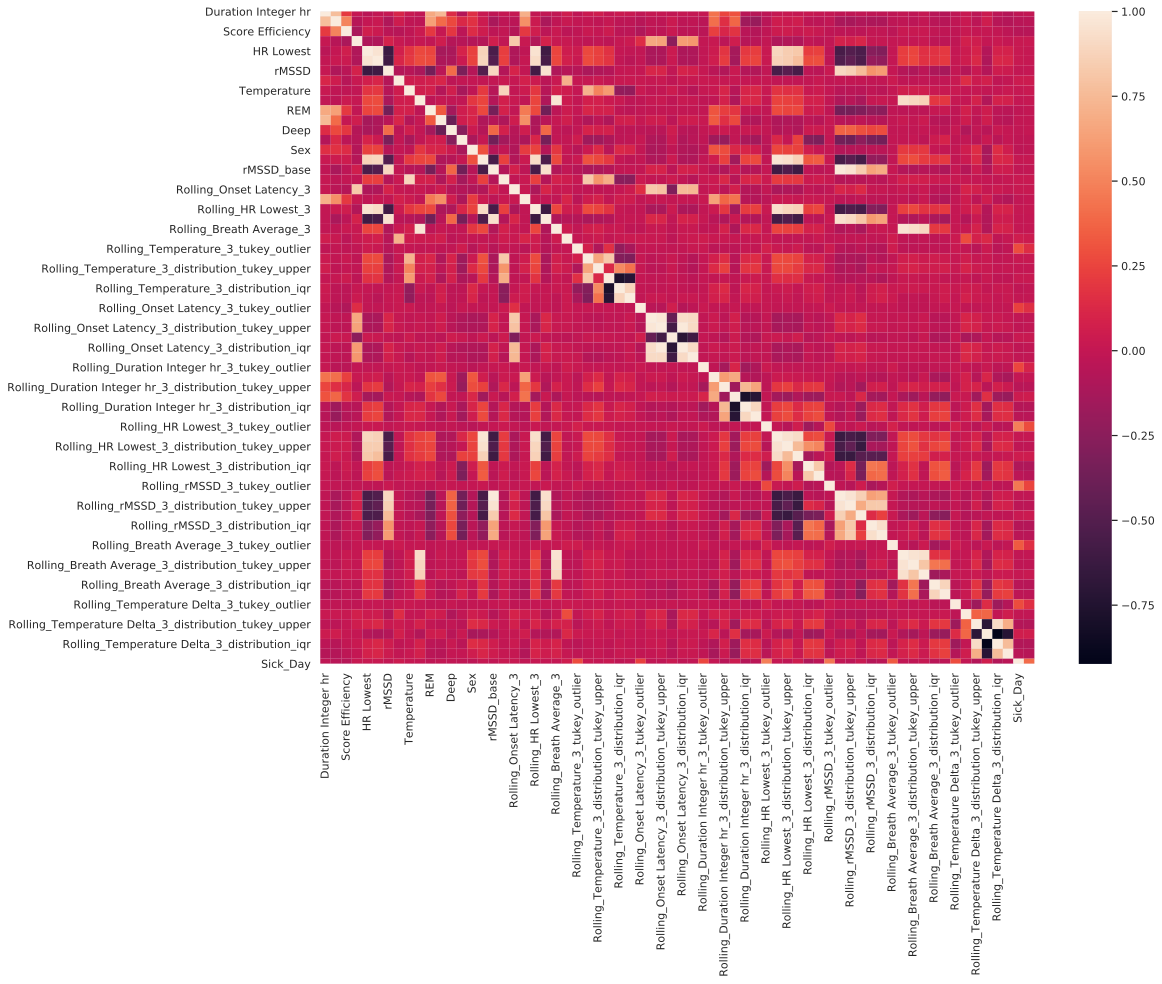

In [20]:
#Plotting the correlation matrix for training dataset
plt.rcParams['figure.figsize'] =  (16,12)
sns.heatmap(train_df.corr());

**Observations**

Since we have 68 features for which the correlation is plotted (barring `Date` and `ID`), we don't view all the features listed. Also, the individual cells in the plot are shrinked.

- On the main diagonal we have got perfect correlation
- The 'brighter' the cell, 'higher' the correlation
- We can see that white colors are present in different cells apart from the diagonal
- Overall, most of the cells are brighter 

Henceforth, it is safe to conclude that there are few features which perfectly correlate (correlation=1) with each other. Most of the other features are highly correlated with each other i.e. these features are proportional and one feature is just calculated based on other. This can be also accounted for the fact that most of features represent distribution of a variable meaning its lower, upper, mean, sigma, iqr values.

#### 3.3 tSNE (t-distributed Stochastic Neighbor Embedding)

Let's say if we have our observations distributed in a d-dimesional space (in our case 68 features meaning 67-d space), we can somehow map the observations on a 2-D plane. Example - If we have two obervations close to each other in D space, then they should be close to each other in 2-D plane. Alternatively, if they are in two different axes in a 4-D space, they should be distant from each other in a 2-D plane.<br>
- This algorithm relies on Maximum Likelihood Estimation
- The idea for this optimisation technique is to find a good mapping from D Dimensional space to a plane or 3D
- Time-consuming
- Very sensitive to hyperparameters like `random_state`
- To apply TSNE(), we need to **drop string valued features**
- No features should have NaN values

We need to set **inplace = True** while executing `df.drop` as we need to modify the original dataframe or alternatively create a new dataframe consisting of only numeric features.

```python
# Documentation on TSNE
?TSNE
```

In [21]:
#Create a new dataframe for training set removing 'Date' and 'ID' columns
tsne_train_df = train_df.drop(['Date', 'ID'], axis = 1)

In [22]:
#Verifying the shape of the newly created dataframe
tsne_train_df.shape

(22267, 68)

In [23]:
#Display first 5 records of 'tsne_train_df'
tsne_train_df.head()

,Duration Integer hr,Sleep Score,Score Efficiency,Onset Latency,HR Lowest,HR Average,rMSSD,Temperature Delta,Temperature,Breath Average,...,Rolling_Breath Average_3_distribution_iqr,Rolling_Breath Average_3_distribution_sigma,Rolling_Temperature Delta_3_tukey_outlier,Rolling_Temperature Delta_3_distribution_mean,Rolling_Temperature Delta_3_distribution_tukey_upper,Rolling_Temperature Delta_3_distribution_tukey_lower,Rolling_Temperature Delta_3_distribution_iqr,Rolling_Temperature Delta_3_distribution_sigma,Sick_Day,Offset_Sick_Day
0,7.70,79.0,81.0,17.5,62.0,75.1,32.0,0.3,97.3,15.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,4.33,65.0,83.0,9.5,61.0,70.0,40.0,0.0,NaN,15.5,...,0.600000,0.355282,0.0,-0.035000,0.575000,-0.625,0.300000,0.217109,0.0,0
2,5.42,73.0,98.0,3.5,54.0,64.2,56.0,0.1,97.3,15.5,...,0.566667,0.345992,0.0,-0.016667,0.600000,-0.600,0.300000,0.214970,0.0,0
3,6.28,83.0,99.0,13.5,58.0,64.7,57.0,0.0,97.0,15.9,...,0.516667,0.335373,0.0,-0.004167,0.541667,-0.525,0.266667,0.209952,0.0,0
4,5.63,75.0,83.0,5.5,60.0,73.7,35.0,-0.1,97.7,15.6,...,0.533333,0.330362,0.0,-0.001282,0.483333,-0.450,0.233333,0.201963,0.0,0


In [24]:
#Drop the rows where at least one element is missing
tsne_train_df = tsne_train_df.dropna()

In [25]:
#Verifying the shape of the newly created dataframe
tsne_train_df.shape

(2618, 68)

This implies that there is no presence of null values for 2618 out of 22267 records corresponding to the 68 features at same time.

In [26]:
#Creating TSNE object
tsne = TSNE(random_state= 17)

In [27]:
#Visualization of whole dataset using TSNE()
#Takes some time to print the output
%time
X_repr = tsne.fit_transform(tsne_train_df)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [28]:
#Takes some time to print the output
%time
X_repr.shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


(2618, 2)

**Observations**

- What the above command does is it finds some nice projection from 67 dimensional space into a 2D plane.
- Shape of the original dataframe: (2618, 68)
- Shape of X_repr: (2618,2)

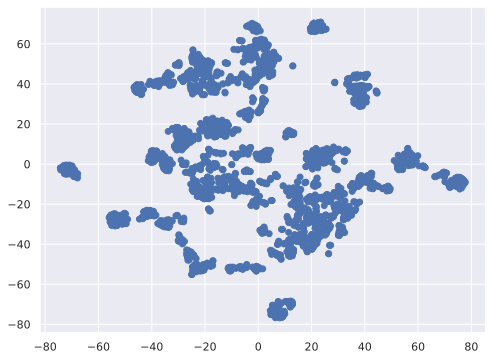

In [29]:
plt.rcParams['figure.figsize'] = (8,6)
plt.scatter(X_repr[:, 0] , X_repr[:, 1]);
#Size of X_repr.shape : (3333,2) => Two columns
#Hence the above command creates a scatterplot for all rows denoted by ':' with each of the two columns

**Observations**

- This is some kind of embedding of the data points onto a plane

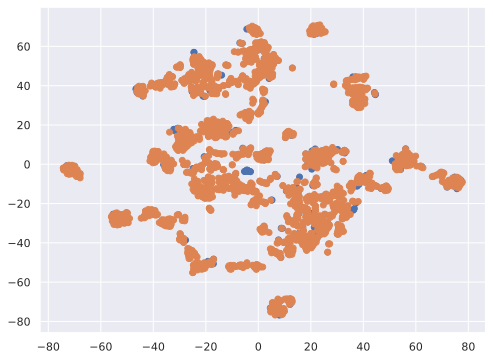

In [30]:
#Finding tSNE with respect to 'Offset_Sick_Day' feature since it's our target feature
plt.rcParams['figure.figsize'] = (8,6)

#Here we are finding tSNE when 
    #a) Churn = 1 with two columns
    #b) Churn = 0 with two columns


plt.scatter(X_repr[tsne_train_df['Offset_Sick_Day']==1,0] , X_repr[tsne_train_df['Offset_Sick_Day']==1,1])
plt.scatter(X_repr[tsne_train_df.Offset_Sick_Day == 0,0], X_repr[tsne_train_df.Offset_Sick_Day == 0,1]);

**Observations**

- We aren't able to view healthy and sick individuals clearly
- Hence, we will introduce `alpha` parameter to increase transparency in the scatter plot
- With tSNE representation, x-axis and y-axis doesn't matter that much as we are projecting in this case 67D space into a 2D plane

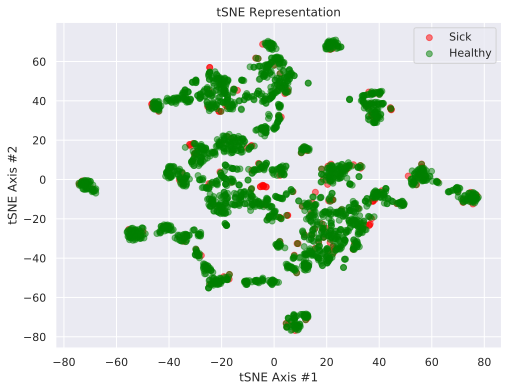

In [31]:
plt.rcParams['figure.figsize'] = (8,6)

plt.scatter(X_repr[tsne_train_df.Offset_Sick_Day == 1, 0] , X_repr[tsne_train_df.Offset_Sick_Day == 1, 1] ,\
            alpha = 0.5, c = 'red' , label = 'Sick')

plt.scatter(X_repr[tsne_train_df['Offset_Sick_Day'] == 0 ,0] , X_repr[tsne_train_df['Offset_Sick_Day'] == 0, 1] ,\
            alpha = 0.5 , c = 'green' , label = 'Healthy')

#It makes no sense to label x-axis and y-axis for TSNE representation
#We are doing it just to have some form of labelling
plt.xlabel ('tSNE Axis #1')
plt.ylabel ('tSNE Axis #2')
plt.title('tSNE Representation')

#What 'hue' is for Seaborn plot, 'legend' is for Matplotlib plot
plt.legend ();

#Save the file
#dpi - picture resolution
#plt.savefig('offset_sick_tsne.png' , dpi = 300)

#### 3.4 Exploring Binary Features

We will take a look at the distribution of `Sick_Day` and `Offset_Sick_Day` which is our target feature for both training and test dataset.

In [32]:
#Identifying the sick individuals on a given day|Training Set
train_df['Sick_Day'].value_counts()

0.0    19712
1.0     1278
Name: Sick_Day, dtype: int64

In [33]:
#Identifying the % of sick individuals on a given day|Training Set
train_df['Sick_Day'].value_counts(normalize=True)

0.0    0.939114
1.0    0.060886
Name: Sick_Day, dtype: float64

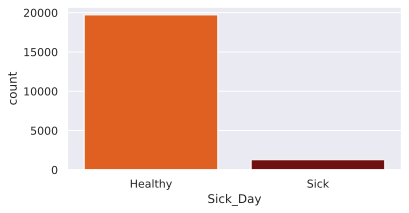

In [34]:
#Plotting 'Sick Day' for training set
plt.rcParams['figure.figsize'] = (6,3)
cp = sns.countplot(x = 'Sick_Day', data = train_df, palette = "gist_heat_r");
cp.set_xticklabels(['Healthy','Sick'])
plt.show()

In [35]:
#Identifying the sick individuals on a given day|Test Set
test_df['Sick_Day'].value_counts()

0.0    4938
1.0     315
Name: Sick_Day, dtype: int64

In [36]:
#Identifying the % of sick individuals on a given day|Test Set
test_df['Sick_Day'].value_counts(normalize=True)

0.0    0.940034
1.0    0.059966
Name: Sick_Day, dtype: float64

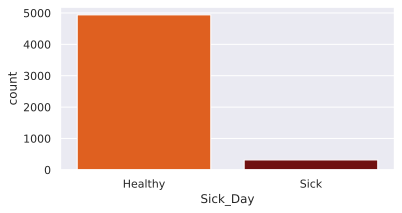

In [37]:
#Plotting 'Sick Day' for test set
plt.rcParams['figure.figsize'] = (6,3)
cp = sns.countplot(x = 'Sick_Day', data = test_df, palette = "gist_heat_r");
cp.set_xticklabels(['Healthy','Sick'])
plt.show()

In [38]:
#Distribution of target feature, 'Offset_Sick_Day'|Training Set
train_df['Offset_Sick_Day'].value_counts()

0    20878
1     1389
Name: Offset_Sick_Day, dtype: int64

In [39]:
#Distribution of target feature, 'Offset_Sick_Day' in %|Training Set
train_df['Offset_Sick_Day'].value_counts(normalize=True)

0    0.937621
1    0.062379
Name: Offset_Sick_Day, dtype: float64

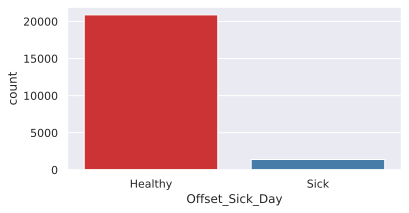

In [40]:
#Plotting 'Offset_Sick_Day' for training set
plt.rcParams['figure.figsize'] = (6,3)
cp = sns.countplot(x = 'Offset_Sick_Day', data = train_df, palette = "Set1");
cp.set_xticklabels(['Healthy','Sick'])
plt.show()

In [41]:
#Distribution of target feature, 'Offset_Sick_Day'|Test Set
test_df['Offset_Sick_Day'].value_counts()

0    5218
1     347
Name: Offset_Sick_Day, dtype: int64

In [42]:
#Distribution of target feature, 'Offset_Sick_Day' in %|Test Set
test_df['Offset_Sick_Day'].value_counts(normalize=True)

0    0.937646
1    0.062354
Name: Offset_Sick_Day, dtype: float64

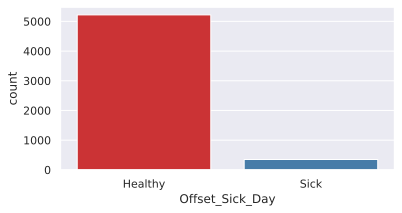

In [43]:
#Plotting 'Offset_Sick_Day' for test set
plt.rcParams['figure.figsize'] = (6,3)
cp = sns.countplot(x = 'Offset_Sick_Day', data = test_df, palette = "Set1");
cp.set_xticklabels(['Healthy','Sick'])
plt.show()

**Observations**

- Both `Sick_Day` and `Offset_Sick_Day` feature class imbalance with most of the records identifying healthy individuals in training and test datasets

#### 3.5 Exploring 'Date' and 'ID' Feature

We need to ensure both `train_df` and `test_df` are sorted by first `ID` followed by `Date` features. This would be required later when we will impute missing values for certain features.

In [44]:
#Sorting by 'ID' followed by 'Date'
train_df = train_df.sort_values(by=['ID', 'Date'])
test_df = test_df.sort_values(by=['ID', 'Date'])

In [45]:
#Verifying the above
train_df[20:25]

,Date,ID,Duration Integer hr,Sleep Score,Score Efficiency,Onset Latency,HR Lowest,HR Average,rMSSD,Temperature Delta,...,Rolling_Breath Average_3_distribution_iqr,Rolling_Breath Average_3_distribution_sigma,Rolling_Temperature Delta_3_tukey_outlier,Rolling_Temperature Delta_3_distribution_mean,Rolling_Temperature Delta_3_distribution_tukey_upper,Rolling_Temperature Delta_3_distribution_tukey_lower,Rolling_Temperature Delta_3_distribution_iqr,Rolling_Temperature Delta_3_distribution_sigma,Sick_Day,Offset_Sick_Day
20,2020-04-20,Athlete Finomore9999,5.82,83.0,99.0,15.5,65.0,71.3,38.0,0.3,...,0.400000,0.299933,0.0,0.077011,0.500000,-0.3000,0.200000,0.196882,0.0,0
21,2020-04-21,Athlete Finomore9999,4.21,63.0,99.0,4.0,52.0,61.9,60.0,-0.7,...,0.450000,0.312655,0.0,0.075556,0.479167,-0.2875,0.191667,0.193732,0.0,0
22,2020-04-22,Athlete Finomore9999,5.86,76.0,98.0,11.0,59.0,75.6,28.0,-0.1,...,0.483333,0.405172,0.0,0.065591,0.495833,-0.3375,0.208333,0.198242,0.0,0
23,2020-04-23,Athlete Finomore9999,5.06,73.0,98.0,11.0,58.0,63.4,54.0,0.1,...,0.516667,0.431333,0.0,0.058333,0.512500,-0.3875,0.225000,0.199261,0.0,0
24,2020-04-24,Athlete Finomore9999,5.51,70.0,95.0,7.5,88.0,96.8,16.0,0.5,...,0.566667,0.440532,0.0,0.049495,0.491667,-0.3750,0.216667,0.202488,0.0,0


In [46]:
#Verifying the above
test_df[100:105]

,Date,ID,Duration Integer hr,Sleep Score,Score Efficiency,Onset Latency,HR Lowest,HR Average,rMSSD,Temperature Delta,...,Rolling_Breath Average_3_distribution_iqr,Rolling_Breath Average_3_distribution_sigma,Rolling_Temperature Delta_3_tukey_outlier,Rolling_Temperature Delta_3_distribution_mean,Rolling_Temperature Delta_3_distribution_tukey_upper,Rolling_Temperature Delta_3_distribution_tukey_lower,Rolling_Temperature Delta_3_distribution_iqr,Rolling_Temperature Delta_3_distribution_sigma,Sick_Day,Offset_Sick_Day
100,2020-07-10,Athlete Garrett9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.545833,0.393965,0.0,-0.115530,0.479167,-0.620833,0.275000,0.274538,0.0,0
101,2020-07-11,Athlete Garrett9995,7.35,75.0,98.0,20.0,55.0,59.8,61.0,-0.5,...,0.570833,0.396761,0.0,-0.112500,0.479167,-0.620833,0.275000,0.275060,0.0,0
102,2020-07-12,Athlete Garrett9995,8.28,77.0,97.0,5.5,52.0,58.0,72.0,-0.5,...,0.570833,0.397931,0.0,-0.117045,0.516667,-0.683333,0.300000,0.276465,0.0,0
103,2020-07-13,Athlete Garrett9995,4.50,49.0,69.0,12.5,55.0,58.0,51.0,0.0,...,0.570833,0.397958,0.0,-0.124621,0.522917,-0.693750,0.304167,0.282228,0.0,0
104,2020-07-14,Athlete Garrett9995,9.03,87.0,99.0,9.5,55.0,60.7,59.0,0.1,...,0.570833,0.398275,0.0,-0.128409,0.560417,-0.756250,0.329167,0.283880,0.0,0


### 4. Data Preprocessing

We will now pre-process the data in a way such that it is model-ready.

#### 4.1 Remove features

Since our dataset contains around 70 features, it is important to only retain features that are important in predicting the target variable `Offset_Sick_Day`. This process is known as **Feature Selection**. There are various techniques to perform feature selection, however for this dataset, we will stick to the manual process. Infact, *correlation* is one of the techniques involved in determining relevant features of a dataset.

- These include 7 sickness indicators along with their 3-day rolling mean and historical 3-day rolling mean, `Sick_Day` and the target variable `Offset_Sick_Day`
- As we have seen in the previous section, features related to `Temperature` have more than 50% missing values and it will not be convenient to impute these values since most of the attribute values will be guessed. Hence, we will remove all the features associated with `Temperature` as well.

In [47]:
new_train_df = train_df[['Date', 'ID', 'Duration Integer hr', 'Rolling_Duration Integer hr_3',\
                        'Rolling_Duration Integer hr_3_distribution_mean', 'Onset Latency',\
                        'Rolling_Onset Latency_3', 'Rolling_Onset Latency_3_distribution_mean',\
                        'HR Lowest', 'Rolling_HR Lowest_3', 'Rolling_HR Lowest_3_distribution_mean',\
                        'rMSSD', 'Rolling_rMSSD_3', 'Rolling_rMSSD_3_distribution_mean',\
                        'Breath Average', 'Rolling_Breath Average_3', 'Rolling_Breath Average_3_distribution_mean',\
                        'Temperature Delta', 'Rolling_Temperature Delta_3', 
                        'Rolling_Temperature Delta_3_distribution_mean',\
                        'Sick_Day','Offset_Sick_Day']].copy()

#An alternative method is to use filter which will create a copy by default:
#new_train_df = train_df.filter(['Col1', 'Col 2'], axis=1)

In [48]:
new_test_df = test_df.filter(['Date', 'ID', 'Duration Integer hr', 'Rolling_Duration Integer hr_3',\
                        'Rolling_Duration Integer hr_3_distribution_mean', 'Onset Latency',\
                        'Rolling_Onset Latency_3', 'Rolling_Onset Latency_3_distribution_mean',\
                        'HR Lowest', 'Rolling_HR Lowest_3', 'Rolling_HR Lowest_3_distribution_mean',\
                        'rMSSD', 'Rolling_rMSSD_3', 'Rolling_rMSSD_3_distribution_mean',\
                        'Breath Average', 'Rolling_Breath Average_3', 'Rolling_Breath Average_3_distribution_mean',\
                        'Temperature Delta', 'Rolling_Temperature Delta_3', 
                        'Rolling_Temperature Delta_3_distribution_mean',\
                        'Sick_Day','Offset_Sick_Day'], axis=1)

In [49]:
#Printing the shape of the new train and test dataframe(s)
print('Shape of new_train_df dataframe: {}'.format(new_train_df.shape))
print('Shape of new_test_df dataframe: {}'.format(new_test_df.shape))

Shape of new_train_df dataframe: (22267, 22)
Shape of new_test_df dataframe: (5565, 22)


#### 4.2 Dealing with missing values

We need to handle the missing values prior fitting the training data to the model. 

- Drop the records for NaN values of `Sick_Day`. As discussed above, there is no definite way to quanitfy the abnormality factor between 3-day rolling mean and historical 3-day rolling mean, thereby it will be difficult to impute the missing values of `Sick_Day` as 0 and 1. Since only around 6% of the `Sick_day` records are NaN values, it doesn't make a huge impact dropping these rows.

For a given sickness indicator and it's *historical 3-day rolling mean* , 

- Impute NaN values with overall mean value of the feature

For *3-day rolling mean* of a given sickness indicator, 

- Impute NaN values by calculating mean of that particular sickness indicator over 3 days. This is the reason why we have sorted both training and test dataframe(s) first by `ID` followed by `Date`


Example - Impute missing values in `Breath Average` and `Rolling_Breath Average_3_distribution_mean` with the mean of the overall value. However, missing value for a given date of `Rolling_Breath Average_3` is computed by calcualting mean of `Breath Average` values for the 3days leading to the current date.

In [50]:
#Account records with non-NaN values of 'Sick_Day' in both new_train_df and new_test_df

new_train_df = new_train_df[new_train_df['Sick_Day'].notna()]
new_test_df = new_test_df[new_test_df['Sick_Day'].notna()]

In [51]:
#Printing the shape of the new train and test dataframe(s)
print('Shape of new_train_df dataframe: {}'.format(new_train_df.shape))
print('Shape of new_test_df dataframe: {}'.format(new_test_df.shape))

Shape of new_train_df dataframe: (20990, 22)
Shape of new_test_df dataframe: (5253, 22)


In [53]:
#Create a list of sickness indicators
col_sick = ['Duration Integer hr', 'Onset Latency', 'HR Lowest', 'rMSSD', 'Breath Average', 'Temperature Delta']

In [54]:
#Imputing missing values for sickness indicators

def replace_miss_values(df):
    
    for feature in col_sick:
        #replace with mean value of the feature
        df[feature] = df[feature].replace(np.nan, df[feature].mean())
        
    return df

In [55]:
#Applying the function to both new train and test dataframe(s)
new_train_df = replace_miss_values(new_train_df)
new_test_df = replace_miss_values(new_test_df)

In [56]:
#Features with null values in new_train_df
new_train_df.isna().any()

Date                                               False
ID                                                 False
Duration Integer hr                                False
Rolling_Duration Integer hr_3                      False
Rolling_Duration Integer hr_3_distribution_mean    False
Onset Latency                                      False
Rolling_Onset Latency_3                            False
Rolling_Onset Latency_3_distribution_mean          False
HR Lowest                                          False
Rolling_HR Lowest_3                                 True
Rolling_HR Lowest_3_distribution_mean               True
rMSSD                                              False
Rolling_rMSSD_3                                     True
Rolling_rMSSD_3_distribution_mean                   True
Breath Average                                     False
Rolling_Breath Average_3                           False
Rolling_Breath Average_3_distribution_mean         False
Temperature Delta              

In [57]:
#Features with null values in new_test_df
new_test_df.isna().any()

Date                                               False
ID                                                 False
Duration Integer hr                                False
Rolling_Duration Integer hr_3                      False
Rolling_Duration Integer hr_3_distribution_mean    False
Onset Latency                                      False
Rolling_Onset Latency_3                            False
Rolling_Onset Latency_3_distribution_mean          False
HR Lowest                                          False
Rolling_HR Lowest_3                                 True
Rolling_HR Lowest_3_distribution_mean               True
rMSSD                                              False
Rolling_rMSSD_3                                     True
Rolling_rMSSD_3_distribution_mean                   True
Breath Average                                     False
Rolling_Breath Average_3                           False
Rolling_Breath Average_3_distribution_mean         False
Temperature Delta              

**Observations**

- `Rolling_HR Lowest_3`, `Rolling_HR Lowest_3_distribution_mean`, `Rolling_rMSSD_3`, `Rolling_rMSSD_3_distribution_mean`, 
`Rolling_Temperature Delta_3`, `Rolling_Temperature Delta_3_distribution_mean` are the features containing null values in both training and test dataset

Now we will impute the missing values for *3-day rolling mean* for the above three sickness indicators.

- Create three separate columns to compute mean values of `HR Lowest`, `rMSSD` and `Temperature Delta`
- Replace the existing null values in `Rolling_HR Lowest_3`, `Rolling_rMSSD_3` and `Rolling_Temperature Delta_3` 
  with the corresponding mean values
- Drop the new columns

In [60]:
def impute_three_day_mean(df):
    
    #Create new feature to store mean values of 'HR Lowest'
    df['mean_HR'] = df['HR Lowest'].rolling(min_periods=1, window=3).mean()
    #Create new feature to store mean values of 'rMSSD'
    df['mean_rMSSD'] = df['rMSSD'].rolling(min_periods=1, window=3).mean()
    #Create new feature to store mean values of 'Temperature Delta'
    df['mean_Temp'] = df['Temperature Delta'].rolling(min_periods=1, window=3).mean()
    #Replace NaN values in 'Rolling_HR Lowest_3' with computed mean
    df['Rolling_HR Lowest_3'] = np.where(df['Rolling_HR Lowest_3'].isnull, df['mean_HR'], df['Rolling_HR Lowest_3'])
    #Replace NaN values in 'Rolling_rMSSD_3' with computed mean
    df['Rolling_rMSSD_3'] = np.where(df['Rolling_rMSSD_3'].isnull, df['mean_rMSSD'], df['Rolling_rMSSD_3'])
    #Replace NaN values in 'Rolling_Temperature Delta_3' with computed mean
    df['Rolling_Temperature Delta_3'] = np.where(df['Rolling_Temperature Delta_3'].isnull, df['mean_Temp'],\
                                                 df['Rolling_Temperature Delta_3'])
    #Drop the computed mean features
    df = df.drop(['mean_HR', 'mean_rMSSD', 'mean_Temp'], axis = 1)
    
    return df

In [63]:
#Applying the function to both new train and test dataframe(s)
new_train_df = impute_three_day_mean(new_train_df)
new_test_df = impute_three_day_mean(new_test_df)

Now we are left with missing values of *3-day historical mean*. Let's impute them as well.

In [68]:
#Imputing missing values for 3-day historical mean in both new train and test dataframe(s)

def impute_hist_mean(df):
    for feature in df.columns:
        if df[feature].dtype == 'float64':
            #replace with mean value of the feature
            df[feature] = df[feature].replace(np.nan, df[feature].mean())
            
    return df

In [69]:
#Applying the above function to both new train and test dataframe(s)
new_train_df = impute_hist_mean(new_train_df)
new_test_df = impute_hist_mean(new_test_df)

In [71]:
print(f'There are {new_train_df.isnull().any().sum()} columns in training dataset with missing values')
print(f'There are {new_test_df.isnull().any().sum()} columns in test dataset with missing values')

There are 0 columns in training dataset with missing values
There are 0 columns in test dataset with missing values


#### 4.3 Drop Date, ID features

Since we have imputed the missing values in both training and test dataset, we can drop `Date` and `ID` features.

In [72]:
new_train_df = new_train_df.drop(['Date', 'ID'], axis = 1)
new_test_df = new_test_df.drop(['Date', 'ID'], axis = 1)

In [73]:
#Printing the shape of the new train and test dataframe(s)
print('Shape of new_train_df dataframe: {}'.format(new_train_df.shape))
print('Shape of new_test_df dataframe: {}'.format(new_test_df.shape))

Shape of new_train_df dataframe: (20990, 20)
Shape of new_test_df dataframe: (5253, 20)


### 5. Train Test Data Split

In [74]:
#Input to the model
X = new_train_df.drop('Offset_Sick_Day', axis = 1)

#Target variable
y = new_train_df['Offset_Sick_Day']

#### 5.1 Splitting the dataset into train and test

We will split our data into train and test in 80:20 ratio before feeding the data to the model. In a way the test data obtained from this split works as a validation dataset before we test our model on the actual test dataset. `X` is the input to the model, while `y` is the target variable.

In [75]:
#Splitting into train and test data in 80:20 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    random_state=42, test_size=0.2, shuffle=True)


#### 5.2 Matthew Correlation Coefficients (MCC)

We know for a fact that accuracy is not the best metric to use while evaluating imbalanced datasets as it can be highly misleading. While metrics like *Confusion Matrix*, *Precision*, *Recall*, *F1 Score* can provide better insights, they are are asymmetric. 

For binary classification, there is another solution: treat the true class and the predicted class as two (binary) variables, and compute their correlation coefficient (in a way similar to computing correlation coefficient between any two variables). The higher the correlation between true and predicted values, the better the prediction. This is the phi-coefficient (φ), rechristened as *Matthews Correlation Coefficient (MCC)* when applied to classifiers.

\begin{equation*}
\Large
MCC = \frac{TP*TN - FP*FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{equation*}


**Properties of MCC** 

- When the classifier is perfect `(FP = FN = 0)`, `MCC = 1`, indicating perfect positive correlation
- Conversely, when the classifier always misclassifies `(TP = TN = 0)`, `MCC = -1`, representing perfect negative correlation
- In fact, MCC value ranges between -1 and 1, with 0 meaning that the classifier is no better than a random flip of a fair coin
- MCC is also perfectly symmetric, so no class is more important than the other; if we switch the positive and negative classes, we will still get the same value
- MCC takes into account all four values in the confusion matrix, and a high value (close to 1) means that both classes are predicted well, even if one class is disproportionately under- (or over-) represented



### 6. Build, Train, Evaluate the Model

As seen above, we have an imbalanced dataset at our disposal. While there are various ways to address class imbalance, in this case we will approach it by using machine learning algorithms that are best suited to handle such problems such as penalized algorithms (which uses `class_weight='balanced'` parameter to penalize mistakes on the minority class by an amount proportional to how under-represented it is) and ensemble algorithms based on *bagging* and *boosting* principle.

In [84]:
#Importing the metrics
from sklearn.metrics import matthews_corrcoef

In [85]:
#Model 1: Penalized-SVM Classifier

from sklearn.svm import SVC
#Adding class_weight='balanced' to enforce penalty
svc = SVC(class_weight='balanced', probability=True)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
mcc_svc = matthews_corrcoef(y_test,y_pred)

print('MCC for SVC Classifier|Validation Set: %.3f'%(mcc_svc))

#Model 2: Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1, class_weight='balanced', max_depth=5)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mcc_dt = matthews_corrcoef(y_test,y_pred)

print('MCC for Decision Tree Classifier|Validation Set: %.3f'%(mcc_dt))

#Model 3: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, class_weight='balanced', max_depth=8)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mcc_rf = matthews_corrcoef(y_test,y_pred)

print('MCC for Random Forest Classifier|Validation Set: %.3f'%(mcc_rf))

#Model 4: LightGBMboost Classifier

#from xgboost import XGBClassifier

MCC for SVC Classifier|Validation Set: 0.164
MCC for Decision Tree Classifier|Validation Set: 0.286
MCC for Random Forest Classifier|Validation Set: 0.387


### 7. Test Model

Now let's see how various models fare on the actual test dataset.

In [80]:
y_holdout_true = new_test_df['Offset_Sick_Day']
X_holdout = new_test_df.drop('Offset_Sick_Day', axis = 1)

In [88]:
#Model 1: Penalized-SVM Classifier

y_holdout_pred = svc.predict(X_holdout)
mcc_holdout_svc = matthews_corrcoef(y_holdout_true,y_holdout_pred)
print('MCC for SVC Classifier|Test Set: %.3f'%(mcc_holdout_svc))

#Model 2: Decision Tree Classifier

y_holdout_pred = dt.predict(X_holdout)
mcc_holdout_dt = matthews_corrcoef(y_holdout_true,y_holdout_pred)
print('MCC for Decision Tree Classifier|Test Set: %.3f'%(mcc_holdout_dt))

#Model 3: Random Forest Classifier

y_holdout_pred = rf.predict(X_holdout)
mcc_holdout_rf = matthews_corrcoef(y_holdout_true,y_holdout_pred)
print('MCC for Random Forest Classifier|Test Set: %.3f'%(mcc_holdout_rf))


MCC for SVC Classifier|Test Set: 0.095
MCC for Decision Tree Classifier|Test Set: 0.243
MCC for Random Forest Classifier|Test Set: 0.372


### 8. Conclusion

- We can clearly see that Random Forest being an ensemble algorithm performs the best and hence has the highest MCC score
- Boosting algorithms like *XgBoost* have higher likelihood of improving performance
- *Oversampling* technique was used to handle the class imbalance by adding more examples to the minority class. But it didn't have good performance on the *mcc* criterion
- While using ensemble tree-based algorithms improved the performance, it's still not optimal. 
- Techniques like **SMOTE** which generates synthetic data for the minority class can be used to tackle class imbalance thereby improving model's performance



### 9. References

- [Matthews Correlation Coefficient: when to use it and when to avoid it](https://towardsdatascience.com/matthews-correlation-coefficient-when-to-use-it-and-when-to-avoid-it-310b3c923f7e)
- [Matthews Correlation Coefficient is The Best Classification Metric You’ve Never Heard Of](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a)
- [Demystifying MCC](https://www.kaggle.com/ratthachat/demythifying-matthew-correlation-coefficients-mcc)
- [scikit-learn documentation on MCC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)